In [8]:
import os
import math
import torch
import random
import numpy as np
import urllib.request
import torch.nn as nn
import torch.utils.data
from pathlib import Path
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision import datasets, transforms

torch.manual_seed(0)

In [2]:
#sin波を生成
def mkDataSet(data_size, data_length=1, freq=60., noise=0.01):
    """
    params\n
    data_size : データセットサイズ\n
    data_length : 各データの時系列長\n
    freq : 周波数\n
    noise : ノイズの振幅\n
    returns\n
    train_x : トレーニングデータ（t=1,2,...,size-1の値)\n
    train_t : トレーニングデータのラベル（t=sizeの値）\n
    """
    train_x = []
    train_t = []
    
    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq) + np.random.normal(loc=1.0, scale=noise)] for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    train_x = np.array(train_x).astype(np.float32) #float.32に型変換必須
    train_t = np.array(train_t).astype(np.float32) #float.32に型変換必須

    return train_x, train_t

In [3]:
def mkRandomBatch(train_x, train_t, batch_size):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])  
    return torch.tensor(batch_x), torch.tensor(batch_t)

In [4]:
class VRAE(nn.Module):
  def __init__(self, inputDim, hiddenDim, outputDim):
    super().__init__()

    self.latent_features = 2
    self.hidden_dim = hiddenDim #LSTMのユニット数
    self.input_dim = inputDim #入力次元数
    self.rnn = nn.LSTM(input_size = inputDim,
                       hidden_size = hiddenDim,
                       batch_first = True)

    self.fc1 = nn.Linear(hiddenDim, self.latent_features) #muを推定するもの
    self.fc2 = nn.Linear(hiddenDim, self.latent_features) #varを推定するもの
    self.fc3 = nn.Linear(self.latent_features, hiddenDim) #サンプリングのための全結合層

    self.output_layer = nn.Linear(hiddenDim, outputDim) #出力

  def encoder(self, inputs):
    output, (hidden, cell) = self.rnn(inputs)
    hidden = hidden.view(-1, hidden.shape[2])
    return hidden

  def decoder(self, inputs, hidden0):
    output, (hidden, cell) = self.rnn(inputs, hidden0)
    return output


  def _reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    esp = torch.randn(*mu.size())
    z = mu + std * esp
    return z
  
  def _bottoleneck(self, h):
    mu, logvar = self.fc1(h), self.fc2(h)
    z = self._reparameterize(mu, logvar)
    return z, mu, logvar
  
  def sampling(self):
    z = torch.randn(64, self.latent_features)
    z = self.fc3(z)
    return self.decoder
  

  def forward(self, x):
    h = self.encoder(x)
    z, mu, logvar = self._bottoleneck(h)
    z = self.fc3(z)

    z = z.view(1, -1, self.hidden_dim)
    cell = torch.zeros(z.shape)
    hidden0 = (z, cell)

    d = self.decoder(x, hidden0)
    d = self.output_layer(d[:, -1, :])

    return d, mu, logvar, z

In [5]:
def loss_function(recon_x, x, mu, logvar):
  MSE = nn.MSELoss()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE(recon_x, x) + KLD

Epoch num:  0


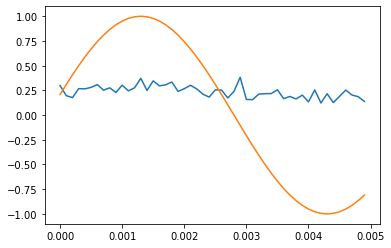

Epoch num:  1


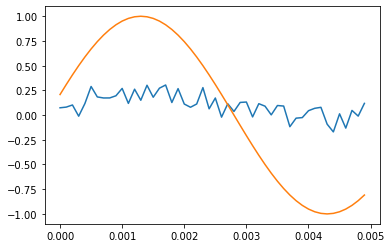

Epoch num:  2


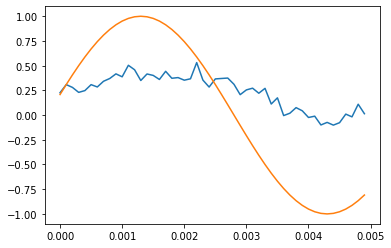

Epoch num:  3


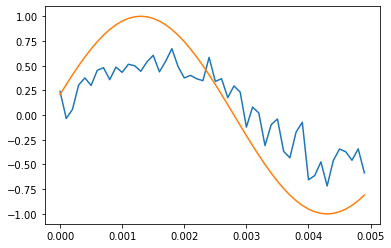

Epoch num:  4


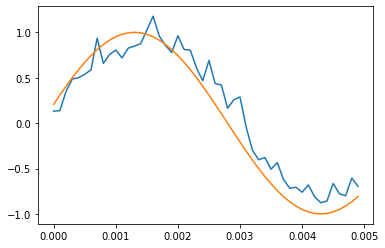

Epoch num:  5


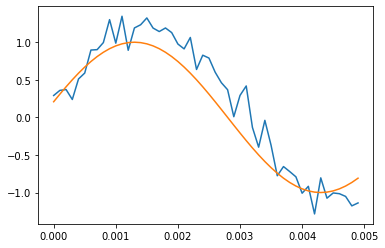

Epoch num:  6


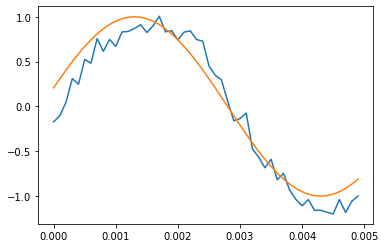

Epoch num:  7


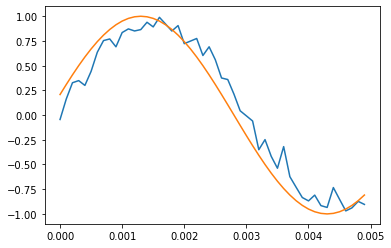

Epoch num:  8


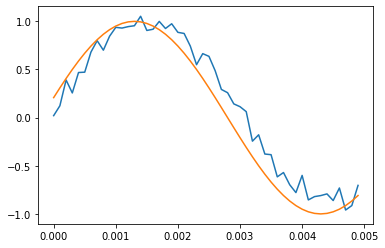

Epoch num:  9


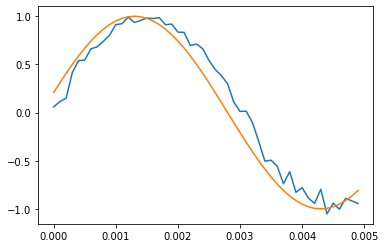

Epoch num:  10


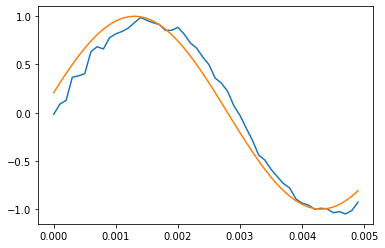

Epoch num:  11


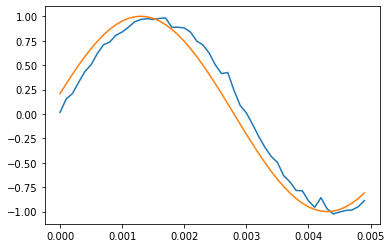

Epoch num:  12


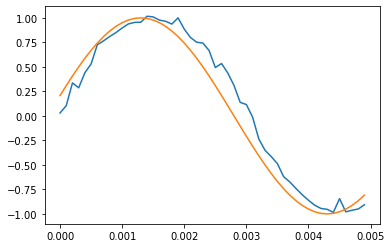

Epoch num:  13


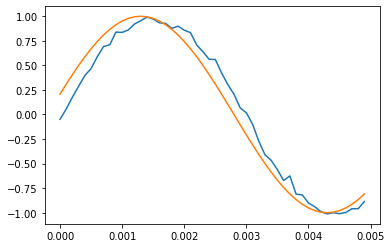

Epoch num:  14


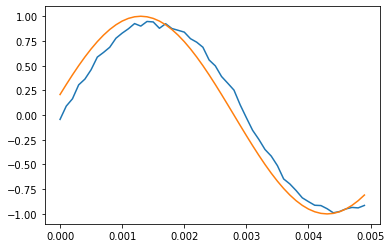

Epoch num:  15


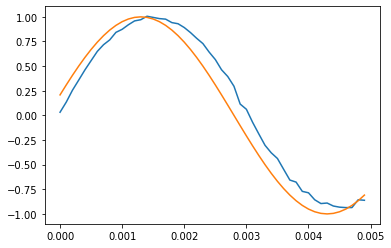

Epoch num:  16


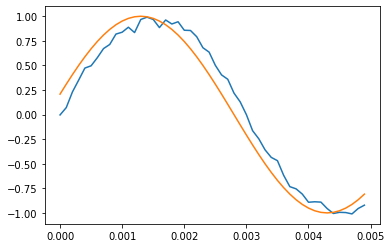

Epoch num:  17


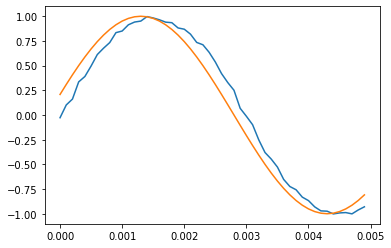

Epoch num:  18


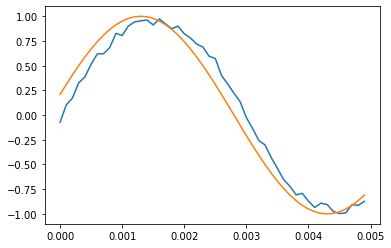

Epoch num:  19


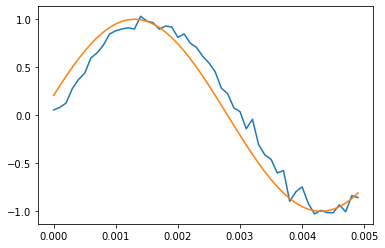

In [13]:
#パラメータ
hidden_size = 40
epochs_num = 20
input_range = 100
batch_size = 12
model = VRAE(1, 20, 1)
optimizer = Adam(model.parameters(), lr=0.01)

train_x, train_t = mkDataSet(input_range)
loss_list = []
z_list_x = []
z_list_y = []


#学習
for epoch in range(epochs_num):
  output_ = []
  for i in range(int(input_range / batch_size)):
    optimizer.zero_grad()
    data, label = mkRandomBatch(train_x, train_t, batch_size)
    recon_batch, mu, logvar, z = model(data)

    
    for i in z:
      z_list_x.append(i[0].detach().numpy())
      z_list_y.append(i[1].detach().numpy())

    loss = loss_function(recon_batch, label, mu, logvar)
    loss_list.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()



    
  #確認用
  output, mu, logvar, z = model(torch.tensor(train_x))
  axis_x = np.linspace(0, 1, 10000)
  output_sin = []
    
  #バッチの先頭のみ抽出
  for i in output:
    output_sin.append(i[0].detach().numpy())
    
    
  print("Epoch num: ", epoch)
  plt.plot(axis_x[0:50], output_sin[0:50])
  plt.plot(axis_x[0:50], train_t[1:51])
  plt.show()
    
    
    
   
   
    

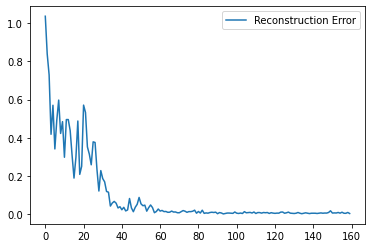

In [14]:
plt.plot(loss_list, label = "Reconstruction Error")
plt.legend()
plt.show()

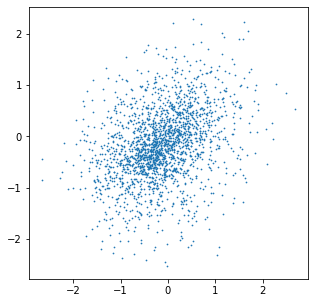

In [19]:
#潜在空間の可視化
plt.figure(figsize= (5,5))
plt.scatter(z_list_x[:100], z_list_y[:100], s = 0.5)